In [167]:

# Learning rate

# Read the file and encode them

import torch
import torch.nn.functional as F
import random

words = open('names.txt', "r").read().splitlines()
random.seed(42)
random.shuffle(words)

stoi = {ch:i+1 for i, ch in enumerate(sorted(set("".join(words))))}
stoi['.'] = 0
itos = {i:ch for ch, i in stoi.items()}

block_size = 3
ch_size = 2
l1 = 200
l2 = 27

x_data = []
y_data = []

# Build the dataset using the context window

for w in words:
    context = [0] * block_size
    #print(w)
    for ch in w + '.':
        idx = stoi[ch]
        x_data.append(context)
        y_data.append(idx)
        #print("".join([itos[i] for i in context]), "--->", ch)
        context = context[1:] + [idx]

# Create the lookup table
x = torch.tensor(x_data)
y = torch.tensor(y_data)
#print(x.shape, y.shape)

g = torch.Generator().manual_seed(2147483647)

# Build the Weight vector (Block size = Hidden Layer - 100, Classifier - 27)
C = torch.randn((27, ch_size), generator=g, requires_grad=True)
W1 = torch.randn((block_size*ch_size, l1), generator=g, requires_grad=True)
b1 = torch.randn((l1,), generator=g, requires_grad=True)
W2 = torch.randn((l1, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
batch_size = 32
print(len(words), x.shape)



32033 torch.Size([228146, 3])


In [168]:
data_size = x.shape[0]
training_idx = int(data_size * 0.8)
validation_idx = int(data_size * 0.9)

In [173]:
# Build Loss
# Build backprop
# Batch size

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

for i in range(10000):
    #build minibatch
    idx = torch.randint(0, training_idx, (batch_size,))
    # Build forward pass
    emb = C[x[idx]]
    X2 = torch.tanh(emb.view(-1, block_size*ch_size) @ W1 + b1)
    logits = X2 @ W2 + b2
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(batch_size), y[idx]].log().mean()
    #loss = F.cross_entropy(logits, y[idx])
    #compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())


2.255629062652588


In [ ]:
import matplotlib.pyplot as plt
plt.plot(lri, lossi)

In [175]:
emb = C[x[training_idx:validation_idx]]
X2 = torch.tanh(emb.view(-1, block_size*ch_size) @ W1 + b1)
logits = X2 @ W2 + b2
loss = F.cross_entropy(logits, y[training_idx:validation_idx])
print(loss.item())

2.4324004650115967


In [188]:

for _ in range(5):
    words = [0] * block_size
    name = []
    while True:
        emb = C[torch.tensor(words)]
        X2 = torch.tanh(emb.view(-1, block_size*ch_size) @ W1 + b1)
        logits = X2 @ W2 + b2
        counts = logits.exp()
        probs = counts/counts.sum(1, keepdim=True)
        next = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        name.append(itos[next.item()])
        words = words[1:] + [next.item()]
        if next.item () == 0:
            break
    print("".join(name))


kene.
wallicin.
ismirian.
ziannid.
gennania.


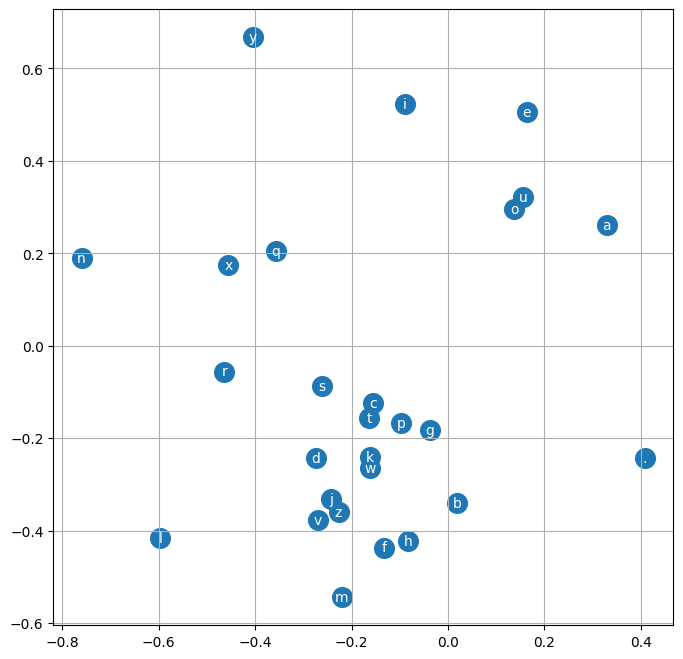

In [187]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')